# Assignment 2

By: Jordan Ponn (996765781) <br>
Course: MIE1513

In [1]:
# import required libraries
# pandas:Data framework library for Python
# sklearn: Library to perform machine learning tasks
import pandas 
import numpy as np
import scipy
import scipy.stats as st
import sklearn 
import sklearn.datasets
import sklearn.metrics as metrics 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import StratifiedKFold
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Constants
BINARY = 0
TERM_FREQUENCY = 1
LOGISTIC_REGRESSION = 0
NAIVE_BAYES = 1

## Create Dataframe

In [3]:
import os
# create file directory for all files
files = []
folders = []
for (path, dirnames, filenames) in os.walk('/resources/data/20_newsgroups'):
    folders.extend(os.path.join(path, name) for name in dirnames)
    files.extend(os.path.join(path, name) for name in filenames)
    
# putting file directories into pandas dataframw
directorydf= pandas.DataFrame(files)
directorydf.columns = ['Directories']
directorydf.head(n=5)

,Directories
0,/resources/data/20_newsgroups/sci.med/59488
1,/resources/data/20_newsgroups/sci.med/59072
2,/resources/data/20_newsgroups/sci.med/58109
3,/resources/data/20_newsgroups/sci.med/59588
4,/resources/data/20_newsgroups/sci.med/59325


In [4]:
# create function to help encoding the targets
def label_target (d):
    if d.find("alt.atheism") > 0 :
      return 0
    if d.find("comp.graphics") > 0:
      return 1
    if d.find("comp.os.ms-windows.misc") > 0:
      return 2
    if d.find("comp.sys.ibm.pc.hardware") > 0:
      return 3
    if d.find("comp.sys.mac.hardware") > 0:
      return 4
    if d.find("comp.windows.x") > 0:
      return 5
    if d.find("misc.forsale") > 0:
      return 6
    if d.find("rec.autos") > 0:
      return 7
    if d.find("rec.motorcycles") > 0:
      return 8
    if d.find("rec.sport.baseball") > 0:
      return 9
    if d.find("rec.sport.hockey") > 0:
      return 10
    if d.find("sci.crypt") > 0:
      return 11
    if d.find("sci.electronics") > 0:
      return 12
    if d.find("sci.med") > 0:
      return 13
    if d.find("sci.space") > 0:
      return 14
    if d.find("soc.religion.christian") > 0:
      return 15
    if d.find("talk.politics.guns") > 0:
      return 16
    if d.find("talk.politics.mideast") > 0:
      return 17
    if d.find("talk.politics.misc") > 0:
      return 18
    if d.find("talk.religion.misc") > 0:
      return 19
    return 'Other'

In [5]:
# Get stopword list
import nltk
# download required resources
nltk.download("stopwords")
stopwords = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/notebook/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
from collections import Counter
import re
import codecs
counter = Counter()
# Open the files and count the word frequency in each file in a loop and update the counter after finished processing a file
for rownum, row in enumerate(directorydf.itertuples()):
    with codecs.open(row.Directories,"r" ,encoding='utf-8', errors='ignore') as myfile:
        # Counter modified from Lab 2 to convert strings to lower case, remove stop words, and remove single letter phrases
        counter.update([word for word in re.findall(r'\w+', myfile.read().lower()) if (word not in stopwords and len(word) > 1)])
    if (rownum % 5000 == 0):
        print("processed %d files" % (rownum+1))
print("Finished processing files!\n")

processed 1 files
processed 5001 files
processed 10001 files
processed 15001 files
Finished processing files!



In [7]:
# Create features based on word frequency
def countWordFrequency(topk, method = BINARY):
    np = []
    print("Starting file processing...\n")
    # now we had top k words, count the frequecy (binary) of these words in individual file
    for rownum, row in enumerate(directorydf.itertuples()):
        with codecs.open(row.Directories,"r" ,encoding='utf-8', errors='ignore') as myfile:
            tempCounter = Counter([word for word in re.findall(r'\w+', myfile.read())])
            
            # Create features
            topkinDoc = 0
            if (method == TERM_FREQUENCY):
                termCount = sum(tempCounter.values())
                topkinDoc = [tempCounter[word]/termCount for (word,wordCount) in topk]
            else:       
                # if the word appears in the doc, then 1, else 
                topkinDoc = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
                
            # create a list for top k words with encoded target and its label
            np.append(topkinDoc+[label_target(row.Directories)]+[row.Directories])
            if (rownum % 5000 == 0):
                print("processed %d files" % (rownum+1))
    
    print("Finished processing files!\n")
    return np

In [8]:
def createDataFrame(numCommonWords, method = BINARY):
    # find top words occured most requent in the document
    topk = counter.most_common(numCommonWords)

    # Create dataframe of word labels and category labels
    df = pandas.DataFrame(countWordFrequency(topk, method))
    dfName = []
    for c in topk:
        dfName.append(c[0])
    df.columns = dfName+['target','label']
    
    return df, dfName

## Prepare Features for Regression

In [9]:
def splitFeaturesFromTarget(dataframe, featureHeaderList, targetHeader = 'target'):
    # select feature attributes from pandas and convert into numpy array
    features_df = dataframe[featureHeaderList]
    features = features_df.as_matrix()
    # select target attribute from pandas and convert into numpy array
    target_df = dataframe[targetHeader]
    target = target_df.as_matrix()
    
    return features, target

## Multiclass Logistic Regression

### 2.) Feature Selection

In [10]:
# Determine starting number of frequent words to use as features
k=1000
newsgroupdf, dfName = createDataFrame(k)
features, target = splitFeaturesFromTarget(newsgroupdf, dfName)

Starting file processing...

processed 1 files
processed 5001 files
processed 10001 files
processed 15001 files
Finished processing files!



In [11]:
# Determine effect of only using top k features
numFeatures = [100*i for i in range(1,11)]
def tuneFeatSel(features, target, classifier = LOGISTIC_REGRESSION):
    featTrainAcc = []
    featTestAcc = []

    # separate datasets into training and test datasets once, no folding
    features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3)

    for k in numFeatures:
        clfModel = ''
        if(classifier == NAIVE_BAYES):
            gnb = MultinomialNB()
            clfModel = gnb.fit(features_train[:,:k], target_train)
        else:
            # use log reg classifier
            clf = LogisticRegression()
            # train the features and target datasets and fit to a model
            clfModel = clf.fit(features_train[:,:k], target_train)
            # predict target with feature test set using trained model
        target_pred = clfModel.predict(features_test[:,:k])

        # Calculate accuracy score, and store it
        featTrainAcc.append(metrics.accuracy_score(target_train, clfModel.predict(features_train[:,:k])))
        score = metrics.accuracy_score(target_test, target_pred)
        featTestAcc.append(score)
        print("The accuracy score for using the top %d words is"  % k, score)
    
    return featTrainAcc, featTestAcc

In [12]:
featTrainAcc, featTestAcc = tuneFeatSel(features, target)

The accuracy score for using the top 100 words is 0.670166666667
The accuracy score for using the top 200 words is 0.814166666667
The accuracy score for using the top 300 words is 0.893166666667
The accuracy score for using the top 400 words is 0.946833333333
The accuracy score for using the top 500 words is 0.946
The accuracy score for using the top 600 words is 0.944333333333
The accuracy score for using the top 700 words is 0.944833333333
The accuracy score for using the top 800 words is 0.945166666667
The accuracy score for using the top 900 words is 0.945333333333
The accuracy score for using the top 1000 words is 0.9445


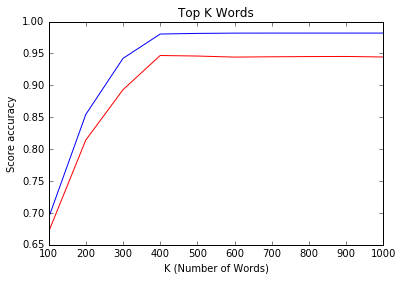

In [13]:
# plot the accuracy scores for each value of k
ax = plt.subplot(111)
ax.plot(numFeatures, featTrainAcc, c='b')
ax.plot(numFeatures, featTestAcc, c='r')
plt.xticks(numFeatures)
plt.title("Top K Words")
ax.set_ylabel('Score accuracy')
ax.set_xlabel('K (Number of Words)')
plt.show()

2.a) Based on the results above, selecting the top 400 common words across the corpus (ignoring stop words, and words shorter than one character) will give a fairly accurate predictive model of determining categories with decent performance speed.  Accuracy appears to plateau after this point, while performance starts to suffer.  This works fairly well because the sample size of checked words is sufficiently large to be able to encompass phrases unique to each topic.

2.b) To automatically determine this number, the number of top words used, k,  was varied, and the overall performance score of the resulting model was compared.  The optimal number of k was selected at a point where performance gains dropped off.  In other words, k was selected such that increasing k would only slow down performance without increasing the accuracy of the model.  As seen in the example above, all tests after 400 words have comparable results.

2.c) The plot shows a quick convergence to the peak performance score in both the test and training sets, as number of features k is varied.  Both show this peak is reached at k=400.  The high training shows that an accurate model was able to be generated when it uses data it has seen before (the training data), while the high test score shows that the model generalizes well (ie. The model is not overfitted to the training data).

### 3.) Tune Hyperparameters

In [14]:
# Determine effect of adjusting hyperparameter C
parameterList = [10**(i-4) for i in range(0,9)]
def tuneHyperPara(features, target, classifier = LOGISTIC_REGRESSION):
    hypTrainAcc = []
    hypTestAcc = []

    # separate datasets into training and test datasets once, no folding
    features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3)

    for para in parameterList:
        clfModel = ''
        
        if(classifier == NAIVE_BAYES):
            # use Naive Bayes classifier
            gnb = MultinomialNB(alpha = para)
            clfModel = gnb.fit(features_train, target_train)
        else:
            # use log reg classifier
            clf = LogisticRegression(C = para)
            # train the features and target datasets and fit to a model
            clfModel = clf.fit(features_train, target_train)
        # predict target with feature test set using trained model
        target_pred = clfModel.predict(features_test)

        # Calculate accuracy score, and store it
        hypTrainAcc.append(metrics.accuracy_score(target_train, clfModel.predict(features_train)))
        score = metrics.accuracy_score(target_test, target_pred)
        hypTestAcc.append(score)
        print("The accuracy score for using hyperparameter = %f is"  % para, score)

    return hypTrainAcc, hypTestAcc

In [15]:
k = 400
hypTrainAcc, hypTestAcc = tuneHyperPara(features[:, :k], target)

The accuracy score for using hyperparameter = 0.000100 is 0.912333333333
The accuracy score for using hyperparameter = 0.001000 is 0.944666666667
The accuracy score for using hyperparameter = 0.010000 is 0.960333333333
The accuracy score for using hyperparameter = 0.100000 is 0.958
The accuracy score for using hyperparameter = 1.000000 is 0.951833333333
The accuracy score for using hyperparameter = 10.000000 is 0.9485
The accuracy score for using hyperparameter = 100.000000 is 0.9455
The accuracy score for using hyperparameter = 1000.000000 is 0.943833333333
The accuracy score for using hyperparameter = 10000.000000 is 0.9425


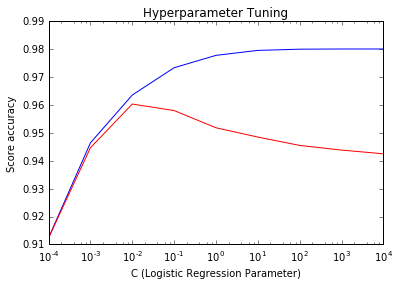

In [16]:
# plot the accuracy scores for each value of c
ax2 = plt.subplot(111)
ax2.plot(parameterList, hypTrainAcc, c='b')
ax2.plot(parameterList, hypTestAcc, c='r')
plt.xticks(parameterList)
plt.title("Hyperparameter Tuning")
ax2.set_ylabel('Score accuracy')
ax2.set_xlabel('C (Logistic Regression Parameter)')
ax2.set_xscale('log')
plt.show() 

3.a) The plot shows that model performance peaks at c = 0.01, then diverges as it increases from there.  This would indicate that changing the default paramter from c = 1 to c = 0.01 would give a slight increase in performance.  Also, any c value beyond c= 0.01 would cause the model to overfit, and generalize poorly with unseen data.

### 4.) Amount of Data

In [17]:
# Determine effect of adjusting amount of training data used
dataAmount = [0.1*i for i in range(1,11)]
k = 400
c = 0.01
amtTrainAcc = []
amtTestAcc = []

# separate datasets into training and test datasets once, no folding
features_train, features_test, target_train, target_test = train_test_split(features[:,:k], target, test_size=0.3)

for p in dataAmount:
    dataIndex = round(len(features)*p)
    # use log reg classifier
    clf = LogisticRegression(C = c)
    # train the features and target datasets and fit to a model
    clfModel = clf.fit(features_train[:dataIndex,:], target_train[:dataIndex])
    # predict target with feature test set using trained model
    target_pred = clfModel.predict(features_test)
    
    # Calculate accuracy score, and store it
    amtTrainAcc.append(metrics.accuracy_score(target_train[:dataIndex], clfModel.predict(features_train[:dataIndex,:])))
    score = metrics.accuracy_score(target_test, target_pred)
    amtTestAcc.append(score)
    print("The accuracy score for using %d percent of the data is"  % round(p*100), score)

The accuracy score for using 10 percent of the data is 0.927
The accuracy score for using 20 percent of the data is 0.946666666667
The accuracy score for using 30 percent of the data is 0.952833333333
The accuracy score for using 40 percent of the data is 0.953833333333
The accuracy score for using 50 percent of the data is 0.954333333333
The accuracy score for using 60 percent of the data is 0.955
The accuracy score for using 70 percent of the data is 0.954833333333
The accuracy score for using 80 percent of the data is 0.954833333333
The accuracy score for using 90 percent of the data is 0.954833333333
The accuracy score for using 100 percent of the data is 0.954833333333


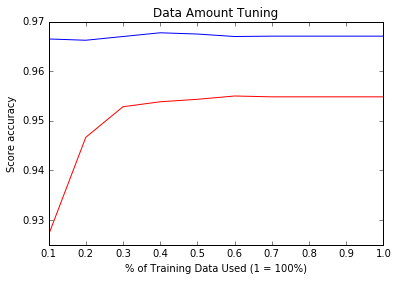

In [18]:
# plot the accuract scores for each data percentage value
ax3 = plt.subplot(111)
ax3.plot(dataAmount, amtTrainAcc, c='b')
ax3.plot(dataAmount, amtTestAcc, c='r')
plt.xticks(dataAmount)
plt.title("Data Amount Tuning")
ax3.set_ylabel('Score accuracy')
ax3.set_xlabel('% of Training Data Used (1 = 100%)')
plt.show() 

4.a) The graph shows that in general, the more data available to train the model, the better.  Some runs show better performance using less data, but this is due to overfitting the model to the training data, as seen by the huge difference between the training and test accuracy scores.  Accuracy scores eventually stabalize once the model has been provided enough variety in samples to generalize a solution.

### 5.) Feature Encoding

In [19]:
# Create dataframe for TF encoded vector
k = 400
newsgroupTfdf, dfTfName = createDataFrame(k, method = TERM_FREQUENCY)
featuresTf, targetTf = splitFeaturesFromTarget(newsgroupTfdf, dfTfName)

Starting file processing...

processed 1 files
processed 5001 files
processed 10001 files
processed 15001 files
Finished processing files!



In [20]:
newsgroupdf[dfTfName+['target','label']].head(n=1)

,edu,ax,cmu,com,cs,news,srv,cantaloupe,net,message,...,colorado,children,left,opinions,away,wed,given,start,target,label
0,1,0,1,0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,13,/resources/data/20_newsgroups/sci.med/59488


In [21]:
newsgroupTfdf.head(n=1)

,edu,ax,cmu,com,cs,news,srv,cantaloupe,net,message,...,colorado,children,left,opinions,away,wed,given,start,target,label
0,0.007009,0.0,0.000584,0.0,0.000584,0.001168,0.000584,0.000584,0.001168,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13,/resources/data/20_newsgroups/sci.med/59488


5.a) See above for the vector representation of both binary and TF encoding (not normalized to a unit vector).

#### k-fold Cross Validation

In [22]:
labelList = newsgroupdf['target'].unique()
# Cross validation with k folds
def kFoldCVTests(features, target, hypPara, folds, ci , classifier = LOGISTIC_REGRESSION, labels=labelList, printTrialScore=False):
    cms = {}
    scores   = []
    cv = StratifiedKFold(target, n_folds=folds)
    for i, (train, test) in enumerate(cv):
        clfModel = ''
        
        if(classifier == NAIVE_BAYES):
            gnb = MultinomialNB(alpha=hypPara)
            clfModel = gnb.fit(features[train], target[train])
        else:     
            # use log reg classifier
            clf = LogisticRegression(C=hypPara)
            # train then immediately predict the test set
            clfModel = clf.fit(features[train], target[train])
            
        target_pred = clfModel.predict(features[test])
        
        # compute the confusion matrix on each fold, convert it to a DataFrame and stash it for later compute
        cms[i] = pandas.DataFrame(metrics.confusion_matrix(target[test], target_pred), columns=labels, index=labels)
        # stash the overall accuracy on the test set for the fold too
        score = metrics.accuracy_score(target[test], target_pred)
        scores.append(score)
        
        if (printTrialScore):
            print("The accuracy score for trial %d is" % i, score)

    print("The average of accuracy score for %d stratified folds is" % folds,np.mean(scores))
    print("The std dev of accuracy score for %d stratified folds is" % folds,np.std(scores))
    print("The std error of the mean accuracy score for %d stratified folds is" % folds,stats.sem(scores))
    print("The %d percent confidence interval range is" % round(ci*100), st.t.interval(ci, len(scores)-1, loc=np.mean(scores), scale=st.sem(scores)))
    
    return cms

In [23]:
folds = 10
ci = 0.95
# k-fold Cross Validation for Binary encoding
binaryCms = kFoldCVTests(features[:,:k],target, 0.01, folds, ci, printTrialScore = True)

The accuracy score for trial 0 is 0.9525
The accuracy score for trial 1 is 0.955
The accuracy score for trial 2 is 0.9545
The accuracy score for trial 3 is 0.961
The accuracy score for trial 4 is 0.958
The accuracy score for trial 5 is 0.9605
The accuracy score for trial 6 is 0.9525
The accuracy score for trial 7 is 0.96148074037
The accuracy score for trial 8 is 0.955477738869
The accuracy score for trial 9 is 0.95847923962
The average of accuracy score for 10 stratified folds is 0.956943771886
The std dev of accuracy score for 10 stratified folds is 0.00323343234133
The std error of the mean accuracy score for 10 stratified folds is 0.00107781078044
The 95 percent confidence interval range is (0.95450559450888639, 0.95938194926299947)


##### Compare with TF Model

###### Not Normalized TF Model

In [24]:
# Determine effect of adjusting hyperparamter C for TF model (not normalized)
hypTrainAccTf, hypTestAccTf = tuneHyperPara(featuresTf, targetTf)

The accuracy score for using hyperparameter = 0.000100 is 0.045
The accuracy score for using hyperparameter = 0.001000 is 0.045
The accuracy score for using hyperparameter = 0.010000 is 0.045
The accuracy score for using hyperparameter = 0.100000 is 0.139166666667
The accuracy score for using hyperparameter = 1.000000 is 0.488666666667
The accuracy score for using hyperparameter = 10.000000 is 0.749166666667
The accuracy score for using hyperparameter = 100.000000 is 0.9125
The accuracy score for using hyperparameter = 1000.000000 is 0.9415
The accuracy score for using hyperparameter = 10000.000000 is 0.943333333333


In [25]:
# k-fold Cross Validation for TF encoding (No normalization)
cTf = 10000
tfCms = kFoldCVTests(featuresTf, targetTf, cTf, folds, ci)

The average of accuracy score for 10 stratified folds is 0.948141970985
The std dev of accuracy score for 10 stratified folds is 0.0038573950315
The std error of the mean accuracy score for 10 stratified folds is 0.00128579834383
The 95 percent confidence interval range is (0.94523329305214832, 0.95105064891883728)


In [26]:
# Convert all datum to unit vectors to normalize for document length
def normalizeFeatures(features):
    normFeatures = []
    
    for row in features:
        mag = np.linalg.norm(row)
        normRow = []
        
        for val in row:
            normRow.append(val/mag)
            
        normFeatures.append(normRow)
    return np.array(normFeatures)

# Convert feature vectors to unit vectors to normalize for document length
normFeatures = normalizeFeatures(featuresTf)

###### Normalized TF Vectors

In [27]:
# Determine effect of adjusting hyperparameter C for TF model (normalized vectors)
hypTrainAccTfNorm, hypTestAccTfNorm = tuneHyperPara(normFeatures, targetTf)

The accuracy score for using hyperparameter = 0.000100 is 0.486
The accuracy score for using hyperparameter = 0.001000 is 0.648666666667
The accuracy score for using hyperparameter = 0.010000 is 0.7495
The accuracy score for using hyperparameter = 0.100000 is 0.876166666667
The accuracy score for using hyperparameter = 1.000000 is 0.941666666667
The accuracy score for using hyperparameter = 10.000000 is 0.951333333333
The accuracy score for using hyperparameter = 100.000000 is 0.949166666667
The accuracy score for using hyperparameter = 1000.000000 is 0.94
The accuracy score for using hyperparameter = 10000.000000 is 0.927666666667


In [28]:
# k-fold Cross Validation for TF encoding (Normalized)
cTfNorm = 10
normTfCms = kFoldCVTests(normFeatures, targetTf, cTfNorm, folds, ci)

The average of accuracy score for 10 stratified folds is 0.950242346173
The std dev of accuracy score for 10 stratified folds is 0.0022653854874
The std error of the mean accuracy score for 10 stratified folds is 0.000755128495801
The 95 percent confidence interval range is (0.94853412683752003, 0.95195056550865309)


5.b) The binary encoded model (c=0.01) performs slightly better than the normalized term-frequency encoded model (c=10), which performed slightly better than the non-normalized term-frequency model (c=10000).  However, the TF models require significantly more regularization (higher c values), which would be akin to increasing the polynomial order in a linear equation.

The term frequency models may be performing worse in this case because they may be going to more detail than needed in order to identify the correct classification label (ie. Binary encoding may be sufficent for this domain).  This additional detail may cause the clusters less distinct.  Also, the non-normalized version needs a lot of regularization in order for it to work in order to compensate for document lengh.

## General Performance

1a.) The chosen settings are: Binary encoding of the top 400 common words as features (excluding nltk stop-words, and words shorter than 1 character), C = 0.01 and use of all training data. 

1b.) See results above for average accuracy score over 10 stratified folds, the individual scores for each trial, and the 95% confidence interval.

1c.) The average accuracy score is a guess as to what how well the model performs, while the 95% confidence interval indicates a range of values which indicates the true performance of the model with 95% certainty.  These are more informative than a single trial as they correct for any bias that may occur through lucky configurations in the training/test data split.

1d.) The train accuracy is always higher than the test accuracy.  This is because the train accuracy is using data that it has already saw, and has trained the model on, while the test accuacy is using data not yet seen by the model.  As a result, the test accuracy is testing to see how well the model generalizes.

In [29]:
# Panel of all test set confusion matrices for binary encoded model
pl = pandas.Panel(binaryCms)
cm = pl.sum(axis=0) #Sum the confusion matrices to get one view of how well the classifiers perform
cm

,13,3,10,0,12,15,2,5,11,19,9,16,7,4,6,17,8,1,18,14
13,798,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,201
3,0,961,10,9,3,14,1,0,0,0,0,0,0,1,1,0,0,0,0,0
10,0,0,1000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,6,993,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
12,0,0,1,10,988,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
15,0,28,9,14,1,946,2,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,7,3,0,983,2,2,0,0,0,3,0,0,0,0,0,0,0
5,0,0,0,0,0,0,6,991,0,0,0,0,3,0,0,0,0,0,0,0
11,0,0,0,0,0,0,7,5,979,4,2,0,0,0,2,0,1,0,0,0
19,0,0,0,0,0,0,0,0,0,994,6,0,0,0,0,0,0,0,0,0


1e.) Of all the topics, there appears to the most confusion over the atheism (Group 0) and misc relgion (Group 19) groupings, followed by the misc politics (Group 18) and misc relgion (Group 19) groupings.  This is caused by the overlap in vocabulary used across these domains, which is not captured within the top 400 common words used as the model features.  Additional features would be required to handle this, such as adding weights to infrequent words, or by giving stronger weights to group specific terms after analyzing and comparing terms in each group.

## 6.) Compare with Naive Bayes

In [30]:
# Determine number of word features needed
featTrainAccNb, featTestAccNb = tuneFeatSel(features, target, NAIVE_BAYES)

The accuracy score for using the top 100 words is 0.586
The accuracy score for using the top 200 words is 0.745333333333
The accuracy score for using the top 300 words is 0.822833333333
The accuracy score for using the top 400 words is 0.9125
The accuracy score for using the top 500 words is 0.913
The accuracy score for using the top 600 words is 0.9125
The accuracy score for using the top 700 words is 0.910833333333
The accuracy score for using the top 800 words is 0.907333333333
The accuracy score for using the top 900 words is 0.91
The accuracy score for using the top 1000 words is 0.91


In [31]:
# Determine effect of adjusting hyperparameter alpha for NB model using binary encoding
hypTrainAccNb, hypTestAccNb = tuneHyperPara(features[:,:k], target, NAIVE_BAYES)

The accuracy score for using hyperparameter = 0.000100 is 0.905833333333
The accuracy score for using hyperparameter = 0.001000 is 0.907
The accuracy score for using hyperparameter = 0.010000 is 0.908333333333
The accuracy score for using hyperparameter = 0.100000 is 0.910166666667
The accuracy score for using hyperparameter = 1.000000 is 0.909
The accuracy score for using hyperparameter = 10.000000 is 0.906666666667
The accuracy score for using hyperparameter = 100.000000 is 0.902333333333
The accuracy score for using hyperparameter = 1000.000000 is 0.852
The accuracy score for using hyperparameter = 10000.000000 is 0.804833333333


In [32]:
# Determine effect of adjusting hyperparameter alpha for NB model using TF encoding (not normalized)
hypTrainAccNbTf, hypTestAccNbTf = tuneHyperPara(featuresTf, targetTf, NAIVE_BAYES)

The accuracy score for using hyperparameter = 0.000100 is 0.694833333333
The accuracy score for using hyperparameter = 0.001000 is 0.689
The accuracy score for using hyperparameter = 0.010000 is 0.669333333333
The accuracy score for using hyperparameter = 0.100000 is 0.574833333333
The accuracy score for using hyperparameter = 1.000000 is 0.259833333333
The accuracy score for using hyperparameter = 10.000000 is 0.0503333333333
The accuracy score for using hyperparameter = 100.000000 is 0.0436666666667
The accuracy score for using hyperparameter = 1000.000000 is 0.0436666666667
The accuracy score for using hyperparameter = 10000.000000 is 0.0436666666667


In [33]:
# Determine effect of adjusting hyperparameter alpha for NB model using TF encoding (normalized)
hypTrainAccNbTfNorm, hypTestAccNbTfNorm = tuneHyperPara(normFeatures, targetTf, NAIVE_BAYES)

The accuracy score for using hyperparameter = 0.000100 is 0.879333333333
The accuracy score for using hyperparameter = 0.001000 is 0.878
The accuracy score for using hyperparameter = 0.010000 is 0.877
The accuracy score for using hyperparameter = 0.100000 is 0.873166666667
The accuracy score for using hyperparameter = 1.000000 is 0.860166666667
The accuracy score for using hyperparameter = 10.000000 is 0.828833333333
The accuracy score for using hyperparameter = 100.000000 is 0.704666666667
The accuracy score for using hyperparameter = 1000.000000 is 0.382166666667
The accuracy score for using hyperparameter = 10000.000000 is 0.0763333333333


In [34]:
# k-fold cross validation with Naive Bayes, Binary encoding
naiveBayesCms = kFoldCVTests(features[:,:k],target, 1, folds, ci, NAIVE_BAYES)

The average of accuracy score for 10 stratified folds is 0.912837293647
The std dev of accuracy score for 10 stratified folds is 0.00588751241526
The std error of the mean accuracy score for 10 stratified folds is 0.00196250413842
The 95 percent confidence interval range is (0.90839780085318611, 0.91727678644046051)


In [35]:
# k-fold cross validation with Naive Bayes, TF encoding(Not normalized)
naiveBayesTfCms = kFoldCVTests(featuresTf,targetTf, 0.0001, folds, ci, NAIVE_BAYES)

The average of accuracy score for 10 stratified folds is 0.87628184092
The std dev of accuracy score for 10 stratified folds is 0.0094334607114
The std error of the mean accuracy score for 10 stratified folds is 0.0031444869038
The 95 percent confidence interval range is (0.86916851734788703, 0.88339516449303346)


In [36]:
# k-fold cross validation with Naive Bayes, TF encoding(Normalized)
naiveBayesTfCms = kFoldCVTests(normFeatures,targetTf, 0.0001, folds, ci, NAIVE_BAYES)

The average of accuracy score for 10 stratified folds is 0.877581990995
The std dev of accuracy score for 10 stratified folds is 0.00645123818771
The std error of the mean accuracy score for 10 stratified folds is 0.00215041272924
The 95 percent confidence interval range is (0.87271741943720749, 0.88244656255378795)


In [37]:
# Panel of all test set confusion matrices for binary encoded model as it had the best performance
pl = pandas.Panel(naiveBayesCms)
cm = pl.sum(axis=0) #Sum the confusion matrices to get one view of how well the classifiers perform
cm

,13,3,10,0,12,15,2,5,11,19,9,16,7,4,6,17,8,1,18,14
13,845,1,0,0,0,1,2,2,0,0,0,1,1,3,1,2,0,5,1,135
3,0,913,12,17,8,27,7,1,0,0,0,7,1,3,4,0,0,0,0,0
10,0,0,989,4,0,3,0,0,0,0,0,2,0,1,0,0,0,0,1,0
0,0,2,3,991,1,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0
12,0,5,0,15,975,0,4,0,0,0,0,1,0,0,0,0,0,0,0,0
15,0,36,27,16,2,902,6,0,0,0,1,8,1,0,0,0,0,0,1,0
2,1,1,3,8,6,0,952,10,1,0,0,1,6,3,3,0,1,0,4,0
5,0,0,0,0,0,1,22,964,4,0,0,0,7,0,0,0,1,0,1,0
11,0,1,0,0,0,0,49,87,779,33,19,0,3,9,11,0,9,0,0,0
19,0,1,0,0,0,0,1,0,0,943,55,0,0,0,0,0,0,0,0,0


6a.) Using the binary encoding, the Naive Bayes classifiers sees worse performance compared to the logistic regression models, but it is significantly faster in terms of speed. Naive Bayes is a simpler classification method which calculates a probability, while the logistic regression uses a threshold function to maps input variables to boolean outputs.  The former is less accurate as it assumes that features are independant, which is not completly true.  However, it is a close enough approximation that, given training data which accounts for this bias, can still perform well.

## MIE1513 - Binary Logistic Regression

In [38]:
# Convert target values from multi-regression (ie. multiple classes) to binary label scheme
# Create function to help convert encodings of the targets
def multiTargetToBinary (val):
    # Performing classification on Group 14 - sci.space
    if val == 14:
      return 1
    return 0

In [39]:
binaryTarget = []
for val in target:
    binaryTarget.append(multiTargetToBinary(val))
binaryTarget = np.array(binaryTarget)

In [40]:
# Determine number of words to use
featTrainAccBinary, featTestAccBinary = tuneFeatSel(features, binaryTarget)

The accuracy score for using the top 100 words is 0.953166666667
The accuracy score for using the top 200 words is 0.996833333333
The accuracy score for using the top 300 words is 0.997166666667
The accuracy score for using the top 400 words is 0.999166666667
The accuracy score for using the top 500 words is 0.998833333333
The accuracy score for using the top 600 words is 0.998666666667
The accuracy score for using the top 700 words is 0.998833333333
The accuracy score for using the top 800 words is 0.998833333333
The accuracy score for using the top 900 words is 0.999333333333
The accuracy score for using the top 1000 words is 0.9995


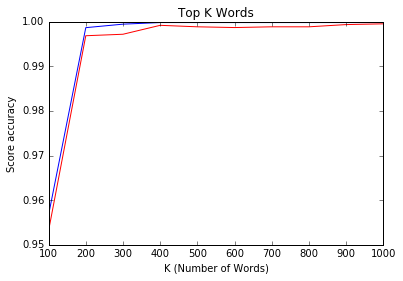

In [41]:
# plot the accuracy scores for each value of k
ax = plt.subplot(111)
ax.plot(numFeatures, featTrainAccBinary, c='b')
ax.plot(numFeatures, featTestAccBinary, c='r')
plt.xticks(numFeatures)
plt.title("Top K Words")
ax.set_ylabel('Score accuracy')
ax.set_xlabel('K (Number of Words)')
plt.show() 

2.1) The two 200 common words are used as features.  This is significantly lower than the multiclass model as the classification requirements in this case are much simpler - instead of identifying among 20 classes, we only need to determine of a document belongs in one specific class or not (sci.space).

2.2) See answer in Multi-class regression for automated way to select k features.

2.3) There is a significant increase in model performance until the word count reaches 200.  After this point, the performance plateaus.

In [42]:
# Determine effect of adjusting hyperparameter c for Binary Logistic Regression model using binary encoding
k = 200
hypTrainAccBinary, hypTestAccBinary = tuneHyperPara(features[:,:k], binaryTarget)

The accuracy score for using hyperparameter = 0.000100 is 0.954
The accuracy score for using hyperparameter = 0.001000 is 0.954
The accuracy score for using hyperparameter = 0.010000 is 0.9885
The accuracy score for using hyperparameter = 0.100000 is 0.996666666667
The accuracy score for using hyperparameter = 1.000000 is 0.996833333333
The accuracy score for using hyperparameter = 10.000000 is 0.996333333333
The accuracy score for using hyperparameter = 100.000000 is 0.996333333333
The accuracy score for using hyperparameter = 1000.000000 is 0.995833333333
The accuracy score for using hyperparameter = 10000.000000 is 0.995666666667


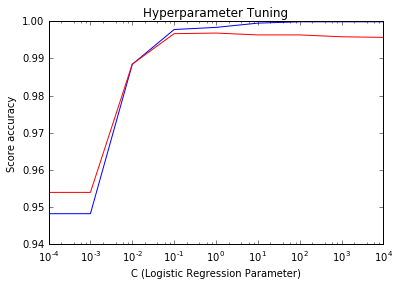

In [43]:
# plot the accuracy scores for each value of c
ax2 = plt.subplot(111)
ax2.plot(parameterList, hypTrainAccBinary, c='b')
ax2.plot(parameterList, hypTestAccBinary, c='r')
plt.xticks(parameterList)
plt.title("Hyperparameter Tuning")
ax2.set_ylabel('Score accuracy')
ax2.set_xlabel('C (Logistic Regression Parameter)')
ax2.set_xscale('log')
plt.show() 

3.1) Performance stays constant until after c=0.001, at which point, it rapidly increases until it starts to plateau at c=0.1

4.1) See answer in Multi-class regression for improved performance with increase in training data volune

5.1) The vector representations are the same as the multi-class regression.  The only difference is the target labels, which were converted from a 20-label solution space to a binary space.

In [44]:
# k-folds cv, binary encoding
binaryCms = kFoldCVTests(features[:,:k],binaryTarget, 0.1, folds, ci, labels = [0,1], printTrialScore = True)

The accuracy score for trial 0 is 0.9955
The accuracy score for trial 1 is 0.9985
The accuracy score for trial 2 is 0.986
The accuracy score for trial 3 is 0.9995
The accuracy score for trial 4 is 0.989
The accuracy score for trial 5 is 1.0
The accuracy score for trial 6 is 0.9985
The accuracy score for trial 7 is 0.99899949975
The accuracy score for trial 8 is 0.999499749875
The accuracy score for trial 9 is 0.99899949975
The average of accuracy score for 10 stratified folds is 0.996449874937
The std dev of accuracy score for 10 stratified folds is 0.00467138493482
The std error of the mean accuracy score for 10 stratified folds is 0.00155712831161
The 95 percent confidence interval range is (0.99292740597406204, 0.99997234390087542)


##### TF Encoding

In [45]:
# Determine effect of adjusting hyperparameter c for Binary Logistic Regression model using tf encoding (no normalizing)
hypTrainAccBinaryTf, hypTestAccBinaryTf = tuneHyperPara(featuresTf[:,:k], binaryTarget)

The accuracy score for using hyperparameter = 0.000100 is 0.955833333333
The accuracy score for using hyperparameter = 0.001000 is 0.955833333333
The accuracy score for using hyperparameter = 0.010000 is 0.955833333333
The accuracy score for using hyperparameter = 0.100000 is 0.955833333333
The accuracy score for using hyperparameter = 1.000000 is 0.955833333333
The accuracy score for using hyperparameter = 10.000000 is 0.956
The accuracy score for using hyperparameter = 100.000000 is 0.970833333333
The accuracy score for using hyperparameter = 1000.000000 is 0.988333333333
The accuracy score for using hyperparameter = 10000.000000 is 0.994666666667


In [46]:
# Determine effect of adjusting hyperparameter C for TF model (normalized vectors)
hypTrainAccBinaryTfNorm, hypTestAccBinaryTfNorm = tuneHyperPara(normFeatures[:,:k], binaryTarget)

The accuracy score for using hyperparameter = 0.000100 is 0.947833333333
The accuracy score for using hyperparameter = 0.001000 is 0.947833333333
The accuracy score for using hyperparameter = 0.010000 is 0.947833333333
The accuracy score for using hyperparameter = 0.100000 is 0.9565
The accuracy score for using hyperparameter = 1.000000 is 0.980333333333
The accuracy score for using hyperparameter = 10.000000 is 0.992
The accuracy score for using hyperparameter = 100.000000 is 0.995
The accuracy score for using hyperparameter = 1000.000000 is 0.994666666667
The accuracy score for using hyperparameter = 10000.000000 is 0.993833333333


In [47]:
# k-fold cv, tf encoding (not normalized)
binaryTfCms = kFoldCVTests(featuresTf[:,:k],binaryTarget, 10000, folds, ci, labels = [0,1])

The average of accuracy score for 10 stratified folds is 0.990849124562
The std dev of accuracy score for 10 stratified folds is 0.00816989055602
The std error of the mean accuracy score for 10 stratified folds is 0.00272329685201
The 95 percent confidence interval range is (0.98468859908224071, 0.99700965004232134)


In [48]:
# k-fold cv, tf encoding (normalized)
binaryTfCms = kFoldCVTests(normFeatures[:,:k],binaryTarget, 100, folds, ci, labels = [0,1])

The average of accuracy score for 10 stratified folds is 0.99099929965
The std dev of accuracy score for 10 stratified folds is 0.00930025530416
The std error of the mean accuracy score for 10 stratified folds is 0.00310008510139
The 95 percent confidence interval range is (0.98398641993261715, 0.99801217936703246)


5b.) Similar to the multi-class model, the binary encoded features performed better than the term frequency ones.  Again, with a simpler classification need, the detail required in the features to correctly identify the classes is significantly reduced.  Overall, TF encoding blur the lines between groups.

In [49]:
# Compare with Naive Bayes
featTrainAccBinaryBn, featTestAccBinaryNb = tuneFeatSel(features, binaryTarget, NAIVE_BAYES)

The accuracy score for using the top 100 words is 0.9465
The accuracy score for using the top 200 words is 0.980333333333
The accuracy score for using the top 300 words is 0.976
The accuracy score for using the top 400 words is 0.991666666667
The accuracy score for using the top 500 words is 0.989666666667
The accuracy score for using the top 600 words is 0.989833333333
The accuracy score for using the top 700 words is 0.988166666667
The accuracy score for using the top 800 words is 0.989
The accuracy score for using the top 900 words is 0.989666666667
The accuracy score for using the top 1000 words is 0.99


In [50]:
k = 400
# Determine effect of adjusting hyperparameter alpha for NB model using binary encoding
hypTrainAccBinaryNb, hypTestAccBinaryNb = tuneHyperPara(features[:,:k], binaryTarget, NAIVE_BAYES)

The accuracy score for using hyperparameter = 0.000100 is 0.994
The accuracy score for using hyperparameter = 0.001000 is 0.994
The accuracy score for using hyperparameter = 0.010000 is 0.994
The accuracy score for using hyperparameter = 0.100000 is 0.994166666667
The accuracy score for using hyperparameter = 1.000000 is 0.9935
The accuracy score for using hyperparameter = 10.000000 is 0.9885
The accuracy score for using hyperparameter = 100.000000 is 0.9445
The accuracy score for using hyperparameter = 1000.000000 is 0.947166666667
The accuracy score for using hyperparameter = 10000.000000 is 0.949


In [51]:
# k-fold cross validation of Naive Bayes with Binary encoding
naiveBayesBinaryCms = kFoldCVTests(features[:,:k],binaryTarget, 0.0001, folds, ci, NAIVE_BAYES, labels = [0,1])

The average of accuracy score for 10 stratified folds is 0.967099074537
The std dev of accuracy score for 10 stratified folds is 0.0648378071637
The std error of the mean accuracy score for 10 stratified folds is 0.0216126023879
The 95 percent confidence interval range is (0.91820797124001663, 1.0159901778345208)


6.a) Similar to the multi-classifier, the Naive Bayes performs worse compared to the logistic regression model.  This is due to the error in calculating the classification probabilities where each feature is assumed to be independant.

1a.) The chosen settings are: Binary encoding of the top 200 common words as features, C = 0.1 and use of all training data.

1b.) See above for all trial runs, average score, and 95% confidence interval

1c.) See answer for multi-classification example.

1d.) See answer for multi-classification example.

In [52]:
# Panel of all test set confusion matrices for binary encoded model
pl = pandas.Panel(binaryCms)
cm = pl.sum(axis=0) #Sum the confusion matrices to get one view of how well the classifiers perform
cm

,0,1
0,18937,60
1,11,989


1e.) There are only a handful of cases which were not classified correctly.  These documents are either missing phrases used in the top common words, or require additional weighting for group specific terms.